In [32]:
import copy
import os
import re

from matplotlib import pyplot as plt
import textgrids
from scipy.io import wavfile
from silence_aligner import extract_segments_from_file
import IPython.display

In [2]:

length_std = {'sil': 0.37004250783970655,
 'g': 0.0970459455376011,
 'a': 0.05660433687030533,
 'f': 0.056929615415985,
 's': 0.10598433935792115,
 'n': 0.044217450983390603,
 'r': 0.025405123070675686,
 'j': 0.06591924956009611,
 'R': 0.0517020847447505,
 'o': 0.060734759874077476,
 'b': 0.06107722854276204,
 'i': 0.04044209198174864,
 'k': 0.09041679558761224,
 'u': 0.050785248251638125,
 'd': 0.053657157384060246,
 'e': 0.04168302088249228,
 'l': 0.05306956815151603,
 'c': 0.08385220938537917,
 'm': 0.05156874573425406,
 't': 0.05078924791058343,
 'p': 0.06496014058103297,
 'y': 0.004456240066948667,
 'C': 0.024831451374519697,
 'N': 0.0,
 '': 0.646766174211673,
 'S': 0.0}

length_avg = {'sil': 0.6619947347517942,
 'g': 0.10168757313538922,
 'a': 0.14216359277803084,
 'f': 0.12765944865075077,
 's': 0.1842492552669475,
 'n': 0.10900618568216998,
 'r': 0.04598977151391705,
 'j': 0.1038708272358285,
 'R': 0.09990348885317477,
 'o': 0.14870062878468995,
 'b': 0.08269588485554184,
 'i': 0.1294199589781047,
 'k': 0.11736411443279583,
 'u': 0.14413120538869068,
 'd': 0.08530152426467356,
 'e': 0.11940625321237626,
 'l': 0.11286410173154132,
 'c': 0.10325003239861755,
 'm': 0.11838473491333955,
 't': 0.07873005754645007,
 'p': 0.06925395812614847,
 'y': 0.11183312549768909,
 'C': 0.12745184747265748,
 'N': 0.05756467874794069,
 '': 0.49404709249643247,
 'S': 0.09273662429796059}

In [3]:
base_file_name = "F_08_1"
os.getcwd()

'/home/ma0/projects/openspeechorg/python-speech-soa/06_alignment'

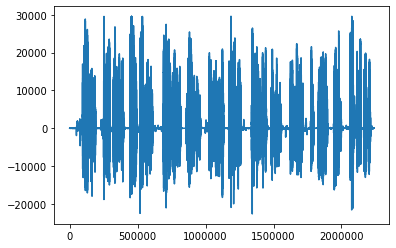

In [4]:
frequency_from_signal, signal = wavfile.read(f"{base_file_name}.wav")
plt.plot(signal)

In [5]:


silences, frequency  = extract_segments_from_file(f"{base_file_name}.wav")

Desired threshold, 0.05
3619967448.9380054


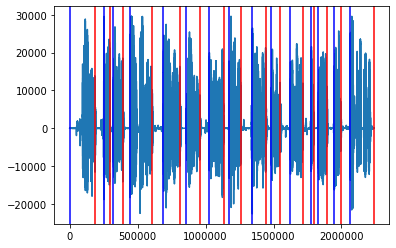

In [6]:

segments = list()
last_start = 0
for start, stop in silences:
    segments.append((last_start, start))
    last_start = stop

segments.append((last_start,signal.shape[-1]))
plt.plot(signal)
for start, stop in segments:
    plt.axvline(start, color="blue")
    plt.axvline(stop, color="red")

In [7]:
def sent_tokenize(text):
    return [x for x in re.split("\.|,|;|:|\n|!|¿|¡|\?|-|—|\(|\)|«|»", text) if x.replace(" ", "")]

with open(f"{base_file_name}.txt") as file:
    text = " ".join(file.readlines())

tokens = sent_tokenize(text)

In [8]:
signal_segment_lengths = [(stop-start)/frequency for start, stop in segments]

In [9]:

sum(signal_segment_lengths)

33.43403628117914

In [10]:
remap = {
    "z": "s",
    "v": "b",
    "q": "k",
    "ñ": "N",
    "h": ""
}

def calculate_token_lengths(text):
    partial_times = list()
    partial_std = list()
    for letter in text:
        letter = remap.get(letter, letter).strip().lower()
        if letter in length_avg:
            partial_times.append(length_avg[letter])
            partial_std.append(length_std[letter])
        else:
            print(f"Letter not found {letter}")
    return sum(partial_times), sum(partial_std)

expected_token_lengths = [calculate_token_lengths(text) for text in tokens]

In [11]:

len(expected_token_lengths)

19

In [12]:

len(signal_segment_lengths)

15

In [13]:
tg = textgrids.TextGrid()
tg.xmin = 0
tg.xmax = silences[-1][1] / frequency
tier = textgrids.Tier()
tg[base_file_name] = tier

index_time = 0
index_text = 0
time = 0

annotation = ""
time_index = 0
for i, (expected_time, std) in enumerate(expected_token_lengths):
    try:
        if expected_time - std < signal_segment_lengths[time_index] < expected_time + std:
            # Correspondencia
            print("First one")
            tier.append(
                    textgrids.Interval(
                        tokens[i],
                        segments[time_index][0]/frequency,
                        segments[time_index][1]/frequency
                    )
                )
            time_index += 1
            time += signal_segment_lengths[time_index]
        elif expected_time - std >  signal_segment_lengths[time_index]:
            print("Second one")
            # Misma anotacion multiples segmentos
            accum_time = signal_segment_lengths[time_index]
            start_index = time_index
            while expected_time - std > accum_time:
                time_index += 1
                accum_time += signal_segment_lengths[time_index]
            end_index = time_index
            tier.append(
                    textgrids.Interval(
                        tokens[i],
                        segments[start_index][0]/frequency,
                        segments[end_index][1]/frequency
                    )
                )
            time += accum_time
            print(time_index)
    except IndexError:
        print("O'o nos pasamos")
        break
tg.write(f"{base_file_name}.TextGrid")

First one
First one
First one
First one
First one
First one
First one
First one
First one
First one
First one
Second one
12
First one
First one
First one
O'o nos pasamos


In [14]:
enum = enumerate(expected_token_lengths)
time_index = 0

In [15]:
i, (expected_time, std) = next(enum)
std = std / 2

In [16]:
start = int(segments[time_index][0])
stop = int(segments[time_index][1])
wave = signal[start: stop]

IPython.display.Audio(wave, rate=frequency)


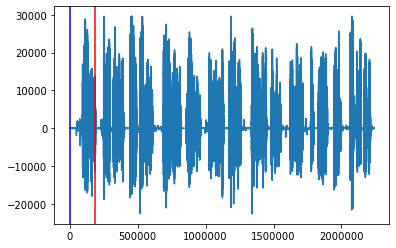

In [17]:
plt.plot(signal)

plt.axvline(start, color="blue")
plt.axvline(stop, color="red")

In [18]:
tokens[i]


'En segura pobreza vive Eumelo'

In [19]:
expected_time - std < signal_segment_lengths[time_index] < expected_time + std

True

In [20]:
print(expected_time)
print(std)
print(signal_segment_lengths[time_index])
expected_time - std

4.9117989638578585
1.9853630327943554
4.3


2.9264359310635033

In [21]:

if expected_time - std < signal_segment_lengths[time_index] < expected_time + std:
    # Correspondencia
    print("First one")
    tier.append(
            textgrids.Interval(
                tokens[i],
                segments[time_index][0]/frequency,
                segments[time_index][1]/frequency
            )
        )
    time_index += 1
    time += signal_segment_lengths[time_index]
elif expected_time - std >  signal_segment_lengths[time_index]:
    print("Second one")
    # Misma anotacion multiples segmentos
    accum_time = signal_segment_lengths[time_index]
    start_index = time_index
    while expected_time - std > accum_time:
        time_index += 1
        accum_time += signal_segment_lengths[time_index]
    end_index = time_index
    tier.append(
            textgrids.Interval(
                tokens[i],
                segments[start_index][0]/frequency,
                segments[end_index][1]/frequency
            )
        )
    time += accum_time
    print(time_index)

First one


In [25]:
EXPECTED_TOKEN_LENGTH = expected_token_lengths
expected_token_lengths

[(4.9117989638578585, 3.970726065588711),
 (3.2046223862313106, 2.794877921727096),
 (2.8607741656180914, 2.4549301689480245),
 (3.367760730874118, 2.8849979387151286),
 (3.6671313277237183, 2.9531222273528104),
 (6.488794852765889, 5.934823334525085),
 (7.062694595493997, 6.180019053897107),
 (7.907481297173224, 6.910444850077052),
 (7.326372525753315, 6.3374638595788015),
 (6.2904768360427985, 5.401472915243971),
 (7.374625530882099, 6.369669566895172),
 (5.851802367731219, 5.239912785119785),
 (6.99749412926276, 6.259753720521496),
 (1.6092074728134624, 1.5447954118262917),
 (4.580738310457955, 3.8198162849763126),
 (4.836817949417482, 4.462422882047053),
 (2.8664437571852344, 2.6223119647969875),
 (2.0396930243830727, 1.7859340282393115),
 (4.291023445001906, 4.0761301287215295)]

In [26]:
SIGNAL_SEGMENT_LENGTHS = signal_segment_lengths
signal_segment_lengths

[4.3,
 1.04,
 1.61,
 3.77,
 2.85,
 2.26,
 2.41,
 1.95,
 2.43,
 1.58,
 2.11,
 0.43,
 1.55,
 1.17,
 3.9740362811791385]

In [64]:
evaluation_stack = [(list(), 0, 0)]

In [65]:
def evaluate_experiment(current_result, expected_index, segment_index):
    while expected_index < len(expected_token_lengths) and segment_index < len(signal_segment_lengths):
        expected_avg, expected_std = EXPECTED_TOKEN_LENGTH[expected_index]
        expected_std = expected_std/2
        segment_length = SIGNAL_SEGMENT_LENGTHS[segment_index]
        if expected_avg - expected_std < segment_length < expected_avg + expected_std:
            print("Segment in range expected")
            current_result.append([[expected_index], [segment_index]])
            expected_index += 1
            segment_index += 1
        elif segment_length < expected_avg - expected_std:
            print("Segment too short")
            cum_length = segment_length
            cum_index = [segment_index]
            segment_index += 1
            while cum_length < expected_avg - expected_std and segment_index < len(signal_segment_lengths):
                print("Appending", expected_index, segment_index)
                evaluation_stack.append((copy.deepcopy(current_result), expected_index, segment_index))
                cum_length += SIGNAL_SEGMENT_LENGTHS[segment_index]
                cum_index.append(segment_index)
                segment_index += 1
            current_result.append([[expected_index], cum_index])
            expected_index += 1
        else:
            print("Segment too long")
            cum_length = expected_avg
            cum_index = [expected_index]
            expected_index += 1
            while cum_length < segment_length and expected_index < len(expected_token_lengths):
                print("Appending", expected_index, segment_index)
                evaluation_stack.append((copy.deepcopy(current_result), expected_index, segment_index))
                cum_length += EXPECTED_TOKEN_LENGTH[expected_index][0]
                cum_index.append(expected_index)
                expected_index += 1
            current_result.append([cum_index, [segment_index]])
            segment_index += 1
    return current_result

# result = evaluate_experiment(list(), 0, 0)

In [66]:
# result_14 = evaluate_experiment(list(), 14, 14)

In [67]:
possible_results = list()

MAX_ITERS = 1000
i = 0
while evaluation_stack and i<MAX_ITERS:
    i += 1
    print("SIZE OF THE STACK", len(evaluation_stack))
    print(evaluation_stack)
    current_experiment = evaluation_stack.pop(0)
    print(current_experiment)
    possible_results.append(evaluate_experiment(current_experiment[0], current_experiment[1], current_experiment[2]))

SIZE OF THE STACK 1
[([], 0, 0)]
([], 0, 0)
Segment in range expected
Segment too short
Appending 1 2
Segment in range expected
Segment in range expected
Segment in range expected
Segment too short
Appending 5 7
Segment too short
Appending 6 9
Segment too short
Appending 7 11
Appending 7 12
Appending 7 13
Segment too short
SIZE OF THE STACK 6
[([[[0], [0]]], 1, 2), ([[[0], [0]], [[1], [1, 2]], [[2], [3]], [[3], [4]], [[4], [5]]], 5, 7), ([[[0], [0]], [[1], [1, 2]], [[2], [3]], [[3], [4]], [[4], [5]], [[5], [6, 7]]], 6, 9), ([[[0], [0]], [[1], [1, 2]], [[2], [3]], [[3], [4]], [[4], [5]], [[5], [6, 7]], [[6], [8, 9]]], 7, 11), ([[[0], [0]], [[1], [1, 2]], [[2], [3]], [[3], [4]], [[4], [5]], [[5], [6, 7]], [[6], [8, 9]]], 7, 12), ([[[0], [0]], [[1], [1, 2]], [[2], [3]], [[3], [4]], [[4], [5]], [[5], [6, 7]], [[6], [8, 9]]], 7, 13)]
([[[0], [0]]], 1, 2)
Segment too short
Appending 1 3
Segment in range expected
Segment in range expected
Segment in range expected
Segment too short
Appending 

In [68]:

possible_results

[[[[0], [0]],
  [[1], [1, 2]],
  [[2], [3]],
  [[3], [4]],
  [[4], [5]],
  [[5], [6, 7]],
  [[6], [8, 9]],
  [[7], [10, 11, 12, 13]],
  [[8], [14]]],
 [[[0], [0]],
  [[1], [2, 3]],
  [[2], [4]],
  [[3], [5]],
  [[4], [6]],
  [[5], [7, 8]],
  [[6], [9, 10, 11]],
  [[7], [12, 13, 14]]],
 [[[0], [0]],
  [[1], [1, 2]],
  [[2], [3]],
  [[3], [4]],
  [[4], [5]],
  [[5], [7, 8]],
  [[6], [9, 10, 11]],
  [[7], [12, 13, 14]]],
 [[[0], [0]],
  [[1], [1, 2]],
  [[2], [3]],
  [[3], [4]],
  [[4], [5]],
  [[5], [6, 7]],
  [[6], [9, 10, 11]],
  [[7], [12, 13, 14]]],
 [[[0], [0]],
  [[1], [1, 2]],
  [[2], [3]],
  [[3], [4]],
  [[4], [5]],
  [[5], [6, 7]],
  [[6], [8, 9]],
  [[7], [11, 12, 13, 14]]],
 [[[0], [0]],
  [[1], [1, 2]],
  [[2], [3]],
  [[3], [4]],
  [[4], [5]],
  [[5], [6, 7]],
  [[6], [8, 9]],
  [[7], [12, 13, 14]]],
 [[[0], [0]],
  [[1], [1, 2]],
  [[2], [3]],
  [[3], [4]],
  [[4], [5]],
  [[5], [6, 7]],
  [[6], [8, 9]],
  [[7], [13, 14]]],
 [[[0], [0]],
  [[1], [3]],
  [[2], [4]],
  [[3],